In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the dataset
dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")

# Extract images and metadata
images = dataset["images"]
metadata = dataset["metadata"]

# Extract labels (assume dx is stored in the first column of metadata)
labels = metadata[:, 0].long()

# Create a DataFrame for clinical data (excluding labels)
clinical_data = pd.DataFrame(metadata[:, 1:].numpy(), columns=[
    f"clinical_{i}" for i in range(1, metadata.size(1))
])

# Store labels and class names
classnames = [
    "Benign lesions of the keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Melanocytic nevi",
    "Vascular lesions",
    "Actinic keratoses"
]
label_dict = {abbr: name for abbr, name in zip(["bkl", "bcc", "df", "mel", "nv", "vasc", "akiec"], classnames)}

# Split data into train and test
train_ratio = 0.85
train_size = int(train_ratio * len(images))
test_size = len(images) - train_size

indices = torch.randperm(len(images)).tolist()  # Shuffle indices
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Split data
X_train_images = images[train_indices]
X_test_images = images[test_indices]
X_train_clin = clinical_data.iloc[train_indices]
X_test_clin = clinical_data.iloc[test_indices]
y_train = labels[train_indices]
y_test = labels[test_indices]

# Create a custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, images, clinical_data, labels):
        self.images = images
        self.clinical_data = clinical_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "clinical_data": torch.tensor(self.clinical_data.iloc[idx].values, dtype=torch.float32),
            "label": self.labels[idx]
        }

# Create datasets
train_dataset = SkinCancerDataset(X_train_images, X_train_clin, y_train)
test_dataset = SkinCancerDataset(X_test_images, X_test_clin, y_test)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print summary
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classnames: {classnames}")
print(f"Label dictionary: {label_dict}")


C:\Users\dasad\AppData\Local\Temp\ipykernel_14332\1618196210.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")


Train size: 5600, Test size: 1400
Classnames: ['Benign lesions of the keratosis', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Melanocytic nevi', 'Vascular lesions', 'Actinic keratoses']
Label dictionary: {'bkl': 'Benign lesions of the keratosis', 'bcc': 'Basal cell carcinoma', 'df': 'Dermatofibroma', 'mel': 'Melanoma', 'nv': 'Melanocytic nevi', 'vasc': 'Vascular lesions', 'akiec': 'Actinic keratoses'}


In [2]:
import torch
import torch.nn as nn

class WeightedResnet(nn.Module):
    def __init__(self, in_channels, num_classes, initial_res_weights=0.001):
        super(WeightedResnet, self).__init__()

        # Initialize res_weights as a learnable parameter
        self.res_weights = nn.Parameter(torch.tensor(initial_res_weights, dtype=torch.float32))

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout(0.1),
            nn.BatchNorm2d(512)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + self.res_weights * x

        x = self.conv3(x)
        x = self.res2(x) + self.res_weights * x

        x = self.conv4(x)
        x = self.res3(x) + self.res_weights * x

        x = self.conv5(x)
        x = self.res4(x) + self.res_weights * x

        x = self.classifier(x)
        x = self.softmax(x)

        return x


In [3]:
class ClinicalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClinicalNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [4]:
class FBP(nn.Module):
    def __init__(self, image_model, clinical_model, num_classes):
        super(FBP, self).__init__()
        self.image_model = image_model
        self.clinical_model = clinical_model
        self.concat_weights = nn.Parameter(torch.ones(2))  
        self.fc1 = nn.Linear(2 * num_classes, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, image, clinical):
        image_features = self.image_model(image)  
        clinical_features = self.clinical_model(clinical)  

        weighted_image_features = self.concat_weights[0] * image_features
        weighted_clinical_features = self.concat_weights[1] * clinical_features
        combined_features = torch.cat([weighted_image_features, weighted_clinical_features], dim=1)

        x = torch.relu(self.fc1(combined_features))
        x = self.fc2(x)
        return x

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Set the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
num_classes = len(set(labels))
resnet_model = WeightedResnet(in_channels=3, num_classes=num_classes).to(device)
clinical_nn = ClinicalNN(input_dim=X_train_clin.shape[1], num_classes=num_classes).to(device)
combined_model = FBP(image_model=resnet_model, clinical_model=clinical_nn, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of epochs
num_epochs = 100

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_recalls = []

# Training loop with tqdm and GPU support
for epoch in range(1, num_epochs + 1):
    combined_model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train the model
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", ncols=100):
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Evaluate on test set
    combined_model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels, all_predictions = [], []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            clinical_data = batch["clinical_data"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = combined_model(images, clinical_data)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Collect labels and predictions for recall computation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute average test loss and accuracy
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test * 100
    test_recall = recall_score(all_labels, all_predictions, average="macro") * 100

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)

    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Recall: {test_recall:.2f}%")

    # Save checkpoint periodically
    if epoch % 10 == 0:
        torch.save(combined_model.state_dict(), f"checkpoint_epoch_{epoch}.pt")

    # Early stopping condition
    if test_accuracy > 95:
        break

# Plot metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))

# Loss curve
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

# Recall curve
plt.subplot(3, 1, 3)
plt.plot(epochs, test_recalls, label="Test Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall (%)")
plt.title("Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.53it/s]


Epoch 1/100
Train Loss: 1.9071, Train Accuracy: 20.39%
Test Loss: 1.6766, Test Accuracy: 31.86%


Epoch 2/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 2/100
Train Loss: 1.5085, Train Accuracy: 39.09%
Test Loss: 1.4706, Test Accuracy: 39.29%


Epoch 3/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 3/100
Train Loss: 1.3379, Train Accuracy: 47.14%
Test Loss: 1.2509, Test Accuracy: 48.64%


Epoch 4/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 4/100
Train Loss: 1.2334, Train Accuracy: 51.11%
Test Loss: 1.2073, Test Accuracy: 55.71%


Epoch 5/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 5/100
Train Loss: 1.2079, Train Accuracy: 53.66%
Test Loss: 1.2236, Test Accuracy: 50.79%


Epoch 6/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 6/100
Train Loss: 1.1676, Train Accuracy: 54.48%
Test Loss: 1.1840, Test Accuracy: 53.14%


Epoch 7/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.55it/s]


Epoch 7/100
Train Loss: 1.1558, Train Accuracy: 53.71%
Test Loss: 1.1311, Test Accuracy: 59.29%


Epoch 8/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 8/100
Train Loss: 1.1425, Train Accuracy: 55.02%
Test Loss: 1.1498, Test Accuracy: 55.21%


Epoch 9/100: 100%|████████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 9/100
Train Loss: 1.0990, Train Accuracy: 56.32%
Test Loss: 1.1454, Test Accuracy: 54.14%


Epoch 10/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.55it/s]


Epoch 10/100
Train Loss: 1.0731, Train Accuracy: 57.50%
Test Loss: 1.0852, Test Accuracy: 58.07%


Epoch 11/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.55it/s]


Epoch 11/100
Train Loss: 1.0335, Train Accuracy: 58.79%
Test Loss: 1.0507, Test Accuracy: 58.36%


Epoch 12/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 12/100
Train Loss: 1.0251, Train Accuracy: 59.11%
Test Loss: 1.1058, Test Accuracy: 57.14%


Epoch 13/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.54it/s]


Epoch 13/100
Train Loss: 1.0130, Train Accuracy: 59.11%
Test Loss: 1.0697, Test Accuracy: 59.86%


Epoch 14/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 14/100
Train Loss: 0.9911, Train Accuracy: 60.00%
Test Loss: 0.9727, Test Accuracy: 60.86%


Epoch 15/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 15/100
Train Loss: 0.9780, Train Accuracy: 61.68%
Test Loss: 1.1741, Test Accuracy: 57.21%


Epoch 16/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 16/100
Train Loss: 0.9301, Train Accuracy: 62.79%
Test Loss: 1.0824, Test Accuracy: 58.29%


Epoch 17/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 17/100
Train Loss: 0.9322, Train Accuracy: 62.82%
Test Loss: 0.9011, Test Accuracy: 64.86%


Epoch 18/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 18/100
Train Loss: 0.8945, Train Accuracy: 64.48%
Test Loss: 0.9614, Test Accuracy: 61.43%


Epoch 19/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 19/100
Train Loss: 0.8946, Train Accuracy: 64.16%
Test Loss: 0.9246, Test Accuracy: 64.43%


Epoch 20/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 20/100
Train Loss: 0.8674, Train Accuracy: 65.16%
Test Loss: 0.8841, Test Accuracy: 64.93%


Epoch 21/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 21/100
Train Loss: 0.8397, Train Accuracy: 66.59%
Test Loss: 0.8544, Test Accuracy: 68.21%


Epoch 22/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 22/100
Train Loss: 0.8377, Train Accuracy: 66.36%
Test Loss: 0.9135, Test Accuracy: 65.14%


Epoch 23/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.55it/s]


Epoch 23/100
Train Loss: 0.8094, Train Accuracy: 67.54%
Test Loss: 0.8476, Test Accuracy: 68.07%


Epoch 24/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 24/100
Train Loss: 0.8245, Train Accuracy: 66.71%
Test Loss: 0.9602, Test Accuracy: 60.07%


Epoch 25/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 25/100
Train Loss: 0.7889, Train Accuracy: 68.39%
Test Loss: 0.8212, Test Accuracy: 68.50%


Epoch 26/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 26/100
Train Loss: 0.7957, Train Accuracy: 68.21%
Test Loss: 0.8376, Test Accuracy: 67.14%


Epoch 27/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 27/100
Train Loss: 0.7662, Train Accuracy: 69.96%
Test Loss: 0.8110, Test Accuracy: 68.64%


Epoch 28/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 28/100
Train Loss: 0.7650, Train Accuracy: 69.55%
Test Loss: 0.7866, Test Accuracy: 69.86%


Epoch 29/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 29/100
Train Loss: 0.7498, Train Accuracy: 70.45%
Test Loss: 0.7833, Test Accuracy: 71.00%


Epoch 30/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 30/100
Train Loss: 0.7218, Train Accuracy: 71.98%
Test Loss: 0.8030, Test Accuracy: 71.21%


Epoch 31/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 31/100
Train Loss: 0.7289, Train Accuracy: 70.43%
Test Loss: 0.8333, Test Accuracy: 68.93%


Epoch 32/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 32/100
Train Loss: 0.7222, Train Accuracy: 71.64%
Test Loss: 0.8027, Test Accuracy: 69.86%


Epoch 33/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 33/100
Train Loss: 0.6842, Train Accuracy: 73.30%
Test Loss: 0.7672, Test Accuracy: 72.50%


Epoch 34/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.55it/s]


Epoch 34/100
Train Loss: 0.6771, Train Accuracy: 73.12%
Test Loss: 0.7739, Test Accuracy: 71.36%


Epoch 35/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 35/100
Train Loss: 0.6696, Train Accuracy: 73.38%
Test Loss: 0.7443, Test Accuracy: 71.93%


Epoch 36/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 36/100
Train Loss: 0.6427, Train Accuracy: 74.55%
Test Loss: 0.8078, Test Accuracy: 69.14%


Epoch 37/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 37/100
Train Loss: 0.6322, Train Accuracy: 74.57%
Test Loss: 0.7955, Test Accuracy: 70.50%


Epoch 38/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 38/100
Train Loss: 0.6453, Train Accuracy: 75.27%
Test Loss: 0.8551, Test Accuracy: 67.86%


Epoch 39/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 39/100
Train Loss: 0.6252, Train Accuracy: 75.02%
Test Loss: 0.7980, Test Accuracy: 72.43%


Epoch 40/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 40/100
Train Loss: 0.6123, Train Accuracy: 75.79%
Test Loss: 0.7606, Test Accuracy: 71.86%


Epoch 41/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 41/100
Train Loss: 0.6129, Train Accuracy: 75.75%
Test Loss: 0.7050, Test Accuracy: 74.71%


Epoch 42/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 42/100
Train Loss: 0.5903, Train Accuracy: 77.20%
Test Loss: 0.7105, Test Accuracy: 74.36%


Epoch 43/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 43/100
Train Loss: 0.5738, Train Accuracy: 77.62%
Test Loss: 0.7699, Test Accuracy: 72.29%


Epoch 44/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 44/100
Train Loss: 0.6039, Train Accuracy: 76.30%
Test Loss: 0.7501, Test Accuracy: 73.21%


Epoch 45/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 45/100
Train Loss: 0.5855, Train Accuracy: 77.30%
Test Loss: 0.7268, Test Accuracy: 74.64%


Epoch 46/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 46/100
Train Loss: 0.5576, Train Accuracy: 78.55%
Test Loss: 0.7039, Test Accuracy: 76.00%


Epoch 47/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 47/100
Train Loss: 0.5691, Train Accuracy: 77.48%
Test Loss: 0.8374, Test Accuracy: 72.86%


Epoch 48/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 48/100
Train Loss: 0.5554, Train Accuracy: 78.82%
Test Loss: 0.6780, Test Accuracy: 76.14%


Epoch 49/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 49/100
Train Loss: 0.5383, Train Accuracy: 78.84%
Test Loss: 0.7649, Test Accuracy: 73.29%


Epoch 50/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 50/100
Train Loss: 0.5218, Train Accuracy: 79.88%
Test Loss: 0.7443, Test Accuracy: 74.29%


Epoch 51/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 51/100
Train Loss: 0.5357, Train Accuracy: 78.91%
Test Loss: 0.8892, Test Accuracy: 68.14%


Epoch 52/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 52/100
Train Loss: 0.5322, Train Accuracy: 79.36%
Test Loss: 0.6759, Test Accuracy: 77.21%


Epoch 53/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.58it/s]


Epoch 53/100
Train Loss: 0.5102, Train Accuracy: 80.02%
Test Loss: 0.6767, Test Accuracy: 77.64%


Epoch 54/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.61it/s]


Epoch 54/100
Train Loss: 0.4817, Train Accuracy: 81.07%
Test Loss: 0.7224, Test Accuracy: 77.07%


Epoch 55/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 55/100
Train Loss: 0.4833, Train Accuracy: 81.32%
Test Loss: 0.6856, Test Accuracy: 76.86%


Epoch 56/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.58it/s]


Epoch 56/100
Train Loss: 0.4760, Train Accuracy: 81.55%
Test Loss: 0.9498, Test Accuracy: 67.43%


Epoch 57/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 57/100
Train Loss: 0.5098, Train Accuracy: 80.27%
Test Loss: 0.7037, Test Accuracy: 76.93%


Epoch 58/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 58/100
Train Loss: 0.4548, Train Accuracy: 82.36%
Test Loss: 0.6742, Test Accuracy: 77.71%


Epoch 59/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 59/100
Train Loss: 0.4556, Train Accuracy: 82.46%
Test Loss: 0.6707, Test Accuracy: 77.79%


Epoch 60/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.58it/s]


Epoch 60/100
Train Loss: 0.4592, Train Accuracy: 81.77%
Test Loss: 0.6748, Test Accuracy: 76.93%


Epoch 61/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 61/100
Train Loss: 0.4649, Train Accuracy: 81.95%
Test Loss: 0.7340, Test Accuracy: 78.00%


Epoch 62/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 62/100
Train Loss: 0.4413, Train Accuracy: 82.71%
Test Loss: 0.7154, Test Accuracy: 73.93%


Epoch 63/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 63/100
Train Loss: 0.4287, Train Accuracy: 83.68%
Test Loss: 0.7117, Test Accuracy: 75.14%


Epoch 64/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 64/100
Train Loss: 0.4272, Train Accuracy: 83.50%
Test Loss: 0.6602, Test Accuracy: 79.07%


Epoch 65/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.51it/s]


Epoch 65/100
Train Loss: 0.4190, Train Accuracy: 84.32%
Test Loss: 0.6903, Test Accuracy: 78.36%


Epoch 66/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 66/100
Train Loss: 0.4342, Train Accuracy: 83.57%
Test Loss: 0.7517, Test Accuracy: 76.57%


Epoch 67/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 67/100
Train Loss: 0.3862, Train Accuracy: 85.20%
Test Loss: 0.6528, Test Accuracy: 78.00%


Epoch 68/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.56it/s]


Epoch 68/100
Train Loss: 0.3851, Train Accuracy: 85.05%
Test Loss: 0.6502, Test Accuracy: 79.86%


Epoch 69/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.58it/s]


Epoch 69/100
Train Loss: 0.4244, Train Accuracy: 84.04%
Test Loss: 0.8304, Test Accuracy: 74.86%


Epoch 70/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 70/100
Train Loss: 0.4010, Train Accuracy: 84.77%
Test Loss: 0.7134, Test Accuracy: 77.00%


Epoch 71/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.59it/s]


Epoch 71/100
Train Loss: 0.3818, Train Accuracy: 85.84%
Test Loss: 0.6925, Test Accuracy: 77.50%


Epoch 72/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.38it/s]


Epoch 72/100
Train Loss: 0.3695, Train Accuracy: 85.82%
Test Loss: 0.6985, Test Accuracy: 77.43%


Epoch 73/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.44it/s]


Epoch 73/100
Train Loss: 0.3658, Train Accuracy: 86.48%
Test Loss: 0.7146, Test Accuracy: 76.64%


Epoch 74/100: 100%|███████████████████████████████████████████████| 175/175 [00:40<00:00,  4.36it/s]


Epoch 74/100
Train Loss: 0.3717, Train Accuracy: 85.55%
Test Loss: 0.7328, Test Accuracy: 75.86%


Epoch 75/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.49it/s]


Epoch 75/100
Train Loss: 0.3782, Train Accuracy: 85.57%
Test Loss: 0.8138, Test Accuracy: 73.86%


Epoch 76/100: 100%|███████████████████████████████████████████████| 175/175 [00:40<00:00,  4.36it/s]


Epoch 76/100
Train Loss: 0.3483, Train Accuracy: 87.39%
Test Loss: 0.6260, Test Accuracy: 81.21%


Epoch 77/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.45it/s]


Epoch 77/100
Train Loss: 0.3393, Train Accuracy: 87.25%
Test Loss: 0.7105, Test Accuracy: 81.43%


Epoch 78/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.58it/s]


Epoch 78/100
Train Loss: 0.3475, Train Accuracy: 86.98%
Test Loss: 1.0040, Test Accuracy: 70.00%


Epoch 79/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.54it/s]


Epoch 79/100
Train Loss: 0.3786, Train Accuracy: 85.48%
Test Loss: 0.7378, Test Accuracy: 78.79%


Epoch 80/100: 100%|███████████████████████████████████████████████| 175/175 [00:40<00:00,  4.35it/s]


Epoch 80/100
Train Loss: 0.3467, Train Accuracy: 86.52%
Test Loss: 0.6637, Test Accuracy: 80.07%


Epoch 81/100: 100%|███████████████████████████████████████████████| 175/175 [00:40<00:00,  4.37it/s]


Epoch 81/100
Train Loss: 0.3342, Train Accuracy: 87.55%
Test Loss: 0.7276, Test Accuracy: 79.07%


Epoch 82/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.63it/s]


Epoch 82/100
Train Loss: 0.3405, Train Accuracy: 87.02%
Test Loss: 0.6672, Test Accuracy: 81.36%


Epoch 83/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 83/100
Train Loss: 0.3150, Train Accuracy: 87.80%
Test Loss: 0.6272, Test Accuracy: 82.07%


Epoch 84/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.44it/s]


Epoch 84/100
Train Loss: 0.3437, Train Accuracy: 87.43%
Test Loss: 0.6536, Test Accuracy: 80.71%


Epoch 85/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.51it/s]


Epoch 85/100
Train Loss: 0.3124, Train Accuracy: 88.68%
Test Loss: 0.6753, Test Accuracy: 82.21%


Epoch 86/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.41it/s]


Epoch 86/100
Train Loss: 0.3059, Train Accuracy: 88.41%
Test Loss: 0.6976, Test Accuracy: 78.93%


Epoch 87/100: 100%|███████████████████████████████████████████████| 175/175 [00:40<00:00,  4.35it/s]


Epoch 87/100
Train Loss: 0.2875, Train Accuracy: 89.00%
Test Loss: 0.6582, Test Accuracy: 81.29%


Epoch 88/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.45it/s]


Epoch 88/100
Train Loss: 0.3073, Train Accuracy: 88.23%
Test Loss: 0.8379, Test Accuracy: 77.07%


Epoch 89/100: 100%|███████████████████████████████████████████████| 175/175 [00:39<00:00,  4.46it/s]


Epoch 89/100
Train Loss: 0.3087, Train Accuracy: 88.30%
Test Loss: 0.7497, Test Accuracy: 79.43%


Epoch 90/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.51it/s]


Epoch 90/100
Train Loss: 0.2698, Train Accuracy: 89.34%
Test Loss: 0.6663, Test Accuracy: 81.86%


Epoch 91/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.61it/s]


Epoch 91/100
Train Loss: 0.3133, Train Accuracy: 88.48%
Test Loss: 0.8649, Test Accuracy: 75.14%


Epoch 92/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 92/100
Train Loss: 0.3066, Train Accuracy: 88.55%
Test Loss: 0.6359, Test Accuracy: 81.93%


Epoch 93/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 93/100
Train Loss: 0.2874, Train Accuracy: 89.66%
Test Loss: 0.6623, Test Accuracy: 81.21%


Epoch 94/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 94/100
Train Loss: 0.2563, Train Accuracy: 90.14%
Test Loss: 0.6806, Test Accuracy: 80.86%


Epoch 95/100: 100%|███████████████████████████████████████████████| 175/175 [00:37<00:00,  4.62it/s]


Epoch 95/100
Train Loss: 0.2740, Train Accuracy: 89.59%
Test Loss: 0.7183, Test Accuracy: 81.00%


Epoch 96/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 96/100
Train Loss: 0.2664, Train Accuracy: 90.00%
Test Loss: 0.7053, Test Accuracy: 79.79%


Epoch 97/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.58it/s]


Epoch 97/100
Train Loss: 0.2591, Train Accuracy: 90.20%
Test Loss: 0.6861, Test Accuracy: 81.64%


Epoch 98/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 98/100
Train Loss: 0.2588, Train Accuracy: 90.29%
Test Loss: 0.7148, Test Accuracy: 81.93%


Epoch 99/100: 100%|███████████████████████████████████████████████| 175/175 [00:38<00:00,  4.60it/s]


Epoch 99/100
Train Loss: 0.2821, Train Accuracy: 89.39%
Test Loss: 0.8072, Test Accuracy: 79.21%


Epoch 100/100: 100%|██████████████████████████████████████████████| 175/175 [00:38<00:00,  4.57it/s]


Epoch 100/100
Train Loss: 0.2669, Train Accuracy: 90.18%
Test Loss: 0.6974, Test Accuracy: 83.50%


In [8]:
torch.save(combined_model, "FinalModelFactorizedBilinearPoolingFusion_full.pt")

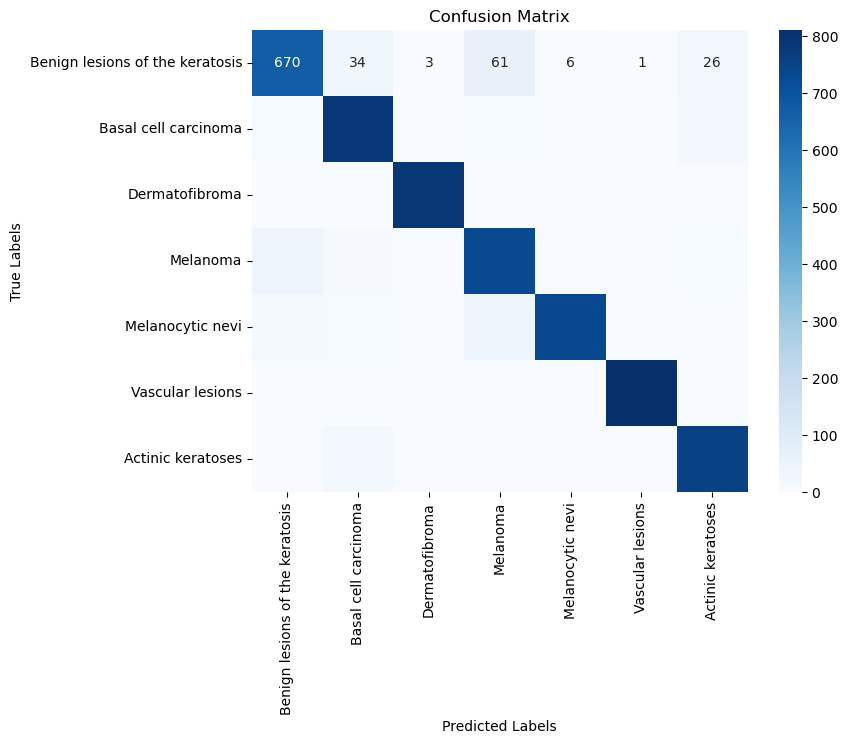

Classification Report:
                                 precision    recall  f1-score   support

Benign lesions of the keratosis       0.91      0.84      0.87       801
           Basal cell carcinoma       0.92      0.95      0.94       821
                 Dermatofibroma       0.99      0.99      0.99       790
                       Melanoma       0.87      0.91      0.89       799
               Melanocytic nevi       0.99      0.92      0.95       797
               Vascular lesions       1.00      1.00      1.00       810
              Actinic keratoses       0.93      0.97      0.95       782

                       accuracy                           0.94      5600
                      macro avg       0.94      0.94      0.94      5600
                   weighted avg       0.94      0.94      0.94      5600



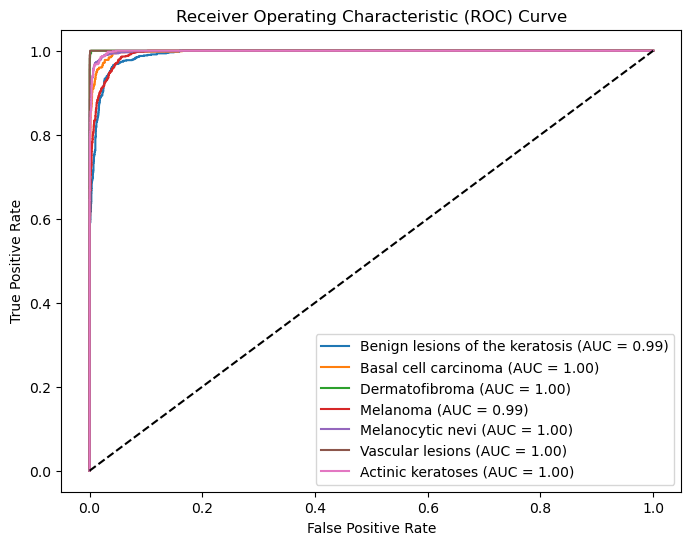

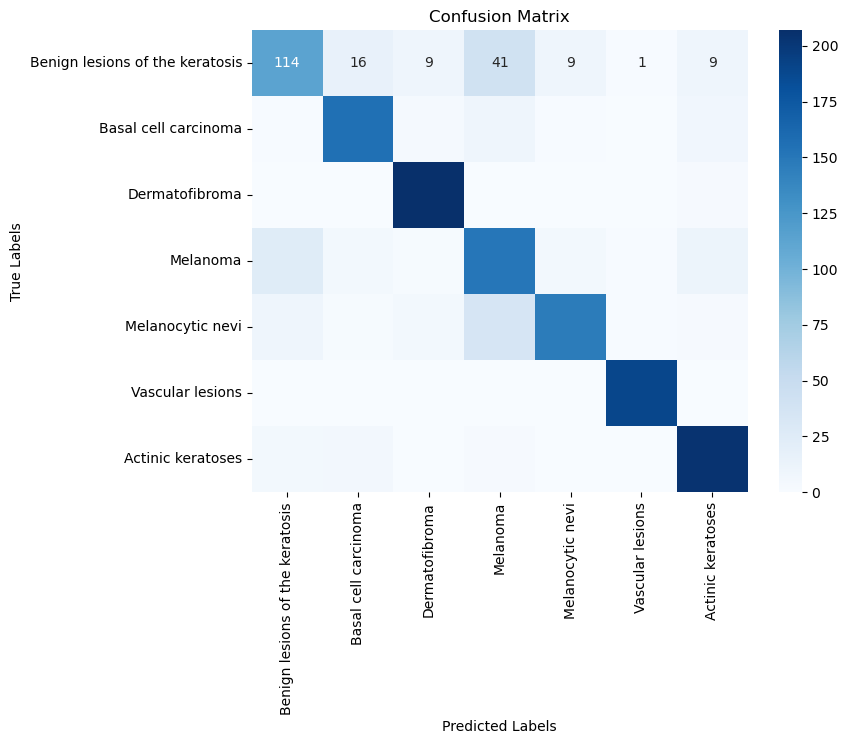

Classification Report:
                                 precision    recall  f1-score   support

Benign lesions of the keratosis       0.74      0.57      0.64       199
           Basal cell carcinoma       0.84      0.87      0.86       179
                 Dermatofibroma       0.91      0.99      0.95       210
                       Melanoma       0.63      0.75      0.69       201
               Melanocytic nevi       0.91      0.72      0.81       203
               Vascular lesions       0.98      1.00      0.99       190
              Actinic keratoses       0.85      0.94      0.89       218

                       accuracy                           0.83      1400
                      macro avg       0.84      0.83      0.83      1400
                   weighted avg       0.84      0.83      0.83      1400



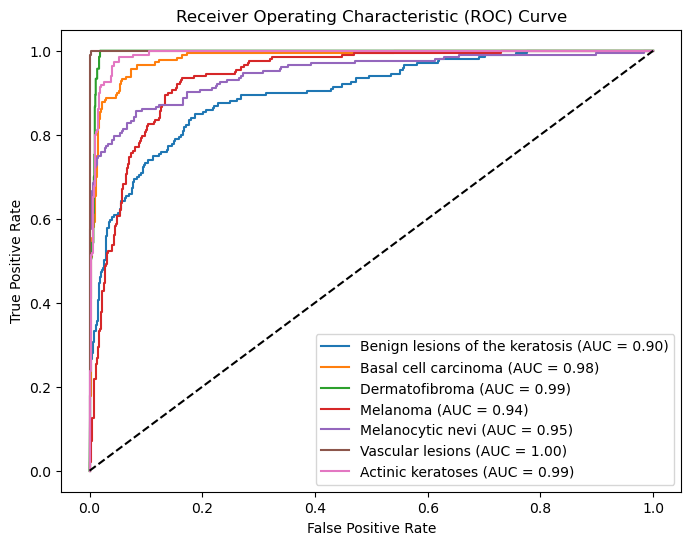

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Function to plot confusion matrix using Matplotlib
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap="Blues")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Labeling the axes
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, class_names):
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to display classification report
def display_classification_report(y_true, y_pred, class_names):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Train Evaluation
combined_model.eval()
train_preds = []
train_labels = []
train_probs = []
with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for train
plot_confusion_matrix(train_labels, train_preds, class_names)
display_classification_report(train_labels, train_preds, class_names)
plot_roc_curve(train_labels, np.array(train_probs), class_names)

# Test Evaluation
combined_model.eval()
test_preds = []
test_labels = []
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Get predictions and probabilities
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Plot confusion matrix and classification report for test
plot_confusion_matrix(test_labels, test_preds, class_names)
display_classification_report(test_labels, test_preds, class_names)
plot_roc_curve(test_labels, np.array(test_probs), class_names)


[[114  16   9  41   9   1   9]
 [  1 156   4   9   1   0   8]
 [  0   0 207   0   0   0   3]
 [ 25   5   2 151   5   1  12]
 [ 10   2   5  35 147   1   3]
 [  0   0   0   0   0 190   0]
 [  5   6   0   3   0   0 204]]


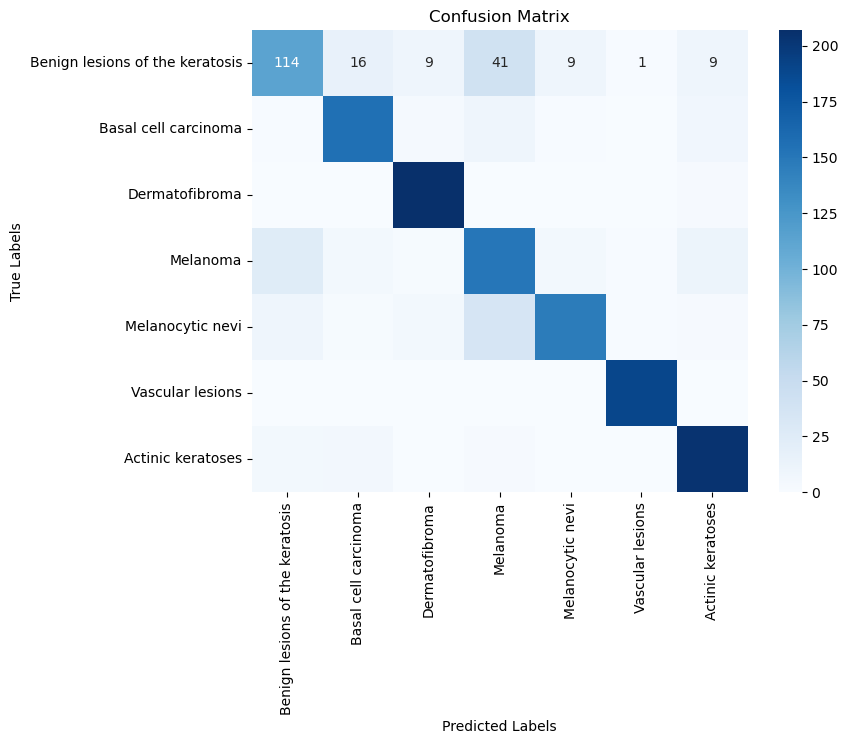

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    print (cm)
    plt.show()
    
plot_confusion_matrix(test_labels, test_preds, class_names)


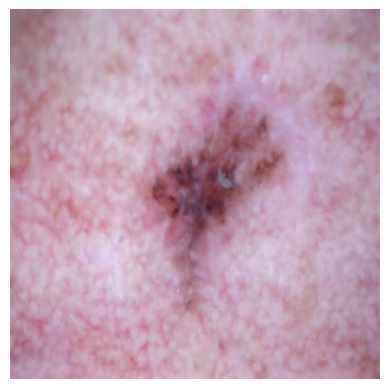

Clinical Data:

Prediction Probabilities:
Benign lesions of the keratosis: 0.0015
Basal cell carcinoma: 0.9817
Dermatofibroma: 0.0000
Melanoma: 0.0167
Melanocytic nevi: 0.0000
Vascular lesions: 0.0000
Actinic keratoses: 0.0001

Actual Class: Basal cell carcinoma
Predicted Class: Basal cell carcinoma


In [15]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as DataFrame (for better display)
clinical_df = pd.DataFrame([sample['clinical_data'].cpu().numpy()], columns=X_train_clin.columns)

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


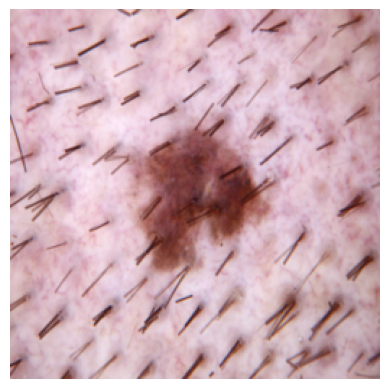

Clinical Data:
    age  dx_type_confocal  dx_type_consensus  dx_type_follow_up  \
0  60.0               0.0                0.0                0.0   

   dx_type_histo  sex_female  sex_male  sex_unknown  local_abdomen  \
0            1.0         0.0       1.0          0.0            0.0   

   local_acral  ...  local_face  local_foot  local_genital  local_hand  \
0          0.0  ...         0.0         0.0            0.0         0.0   

   local_lower extremity  local_neck  local_scalp  local_trunk  local_unknown  \
0                    0.0         0.0          1.0          0.0            0.0   

   local_upper extremity  
0                    0.0  

[1 rows x 23 columns]

Prediction Probabilities:
Benign lesions of the keratosis: 0.0030
Basal cell carcinoma: 0.2132
Dermatofibroma: 0.0000
Melanoma: 0.0001
Melanocytic nevi: 0.0000
Vascular lesions: 0.0000
Actinic keratoses: 0.7838

Actual Class: Actinic keratoses
Predicted Class: Actinic keratoses


In [19]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as DataFrame (for better display)
clinical_df = pd.DataFrame([sample['clinical_data'].cpu().numpy()], columns=[
    'age', 'dx_type_confocal', 'dx_type_consensus', 'dx_type_follow_up', 
    'dx_type_histo', 'sex_female', 'sex_male', 'sex_unknown', 'local_abdomen', 
    'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 
    'local_foot', 'local_genital', 'local_hand', 'local_lower extremity', 
    'local_neck', 'local_scalp', 'local_trunk', 'local_unknown', 'local_upper extremity'
])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


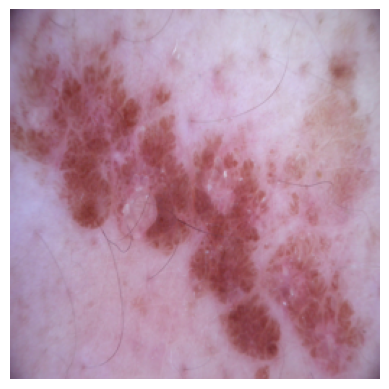

Clinical Data:
    Age    Dx Type      Sex  Localization
0  50.0  Follow-up  Unknown  Abdomen, Ear

Prediction Probabilities:
Benign lesions of the keratosis: 0.7693
Basal cell carcinoma: 0.0000
Dermatofibroma: 0.0000
Melanoma: 0.0000
Melanocytic nevi: 0.2307
Vascular lesions: 0.0000
Actinic keratoses: 0.0000

Actual Class: Benign lesions of the keratosis
Predicted Class: Benign lesions of the keratosis


In [22]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as a DataFrame (for better display)
clinical_data_dict = sample['clinical_data'].cpu().numpy()

# Determine the dx_type based on the columns 'dx_type_confocal', 'dx_type_consensus', and 'dx_type_follow_up'
dx_type = ''
if clinical_data_dict[0] == 1:
    dx_type = 'Confocal'
elif clinical_data_dict[1] == 1:
    dx_type = 'Consensus'
elif clinical_data_dict[2] == 1:
    dx_type = 'Follow-up'

# Determine the sex based on the 'sex_female' and 'sex_male' columns
sex = ''
if clinical_data_dict[4] == 1:
    sex = 'Female'
elif clinical_data_dict[5] == 1:
    sex = 'Male'
else:
    sex = 'Unknown'

# Determine the localization (only the body part where lesion is located is shown)
localization = []
local_columns = [
    'local_abdomen', 'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 'local_foot',
    'local_genital', 'local_hand', 'local_lower extremity', 'local_neck', 'local_scalp', 'local_trunk',
    'local_unknown', 'local_upper extremity'
]
for i, loc in enumerate(local_columns):
    if clinical_data_dict[i + 6] == 1:  # Skip the first 6 columns for dx_type and sex
        localization.append(loc.replace('local_', '').replace('_', ' ').capitalize())

# Create the DataFrame
clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


In [24]:
clinical_df

,Age,Dx Type,Sex,Localization
0,50.0,Follow-up,Unknown,"Abdomen, Ear"


TypeError: GatedFusion.forward() missing 1 required positional argument: 'clinical'

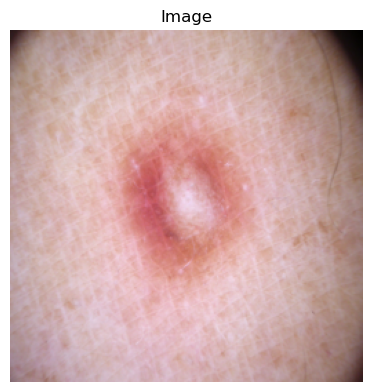

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import models

# Grad-CAM function
def generate_gradcam(model, image, class_idx):
    # Hook the feature extractor layer to get the gradients
    def hook_fn(module, input, output):
        return output

    # Register hook on the last convolutional layer of the resnet
    final_conv_layer = model.image_model.conv5[0]  # Last convolutional layer
    hook = final_conv_layer.register_forward_hook(hook_fn)

    # Forward pass to get the model's output
    model.eval()
    output = model(image)
    
    # Zero out gradients and perform backward pass
    model.zero_grad()
    target_class = output[0, class_idx]
    target_class.backward()

    # Get the gradients and activations
    gradients = final_conv_layer.weight.grad
    activations = hook.output

    # Pool the gradients across the channels to get the importance weight for each feature map
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight the feature maps by the gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the weighted feature maps to create the heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Apply ReLU to the heatmap
    heatmap = F.relu(heatmap)
    
    # Normalize the heatmap between 0 and 1
    heatmap /= torch.max(heatmap)
    
    # Remove the hook
    hook.remove()

    return heatmap.cpu().numpy()

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as a DataFrame (for better display)
clinical_data_dict = sample['clinical_data'].cpu().numpy()

# Determine the dx_type based on the columns 'dx_type_confocal', 'dx_type_consensus', and 'dx_type_follow_up'
dx_type = ''
if clinical_data_dict[0] == 1:
    dx_type = 'Confocal'
elif clinical_data_dict[1] == 1:
    dx_type = 'Consensus'
elif clinical_data_dict[2] == 1:
    dx_type = 'Follow-up'

# Determine the sex based on the 'sex_female' and 'sex_male' columns
sex = ''
if clinical_data_dict[4] == 1:
    sex = 'Female'
elif clinical_data_dict[5] == 1:
    sex = 'Male'
else:
    sex = 'Unknown'

# Determine the localization (only the body part where lesion is located is shown)
localization = []
local_columns = [
    'local_abdomen', 'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 'local_foot',
    'local_genital', 'local_hand', 'local_lower extremity', 'local_neck', 'local_scalp', 'local_trunk',
    'local_unknown', 'local_upper extremity'
]
for i, loc in enumerate(local_columns):
    if clinical_data_dict[i + 6] == 1:  # Skip the first 6 columns for dx_type and sex
        localization.append(loc.replace('local_', '').replace('_', ' ').capitalize())

# Create the DataFrame
clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.title("Image")

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(combined_model, image, predicted_class)

# Plot Grad-CAM
plt.subplot(1, 2, 2)
plt.imshow(sample['image'].permute(1, 2, 0).cpu().numpy())
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.axis('off')
plt.title("Grad-CAM Heatmap")

plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])

# Plot bar graph for clinical data visualization
clinical_data_values = {
    'Age': clinical_data_dict[0],
    'Sex': sex,
    'Dx Type': dx_type,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}

fig, ax = plt.subplots(figsize=(8, 5))

# Plot Age (as a numerical value)
ax.barh(['Age'], [clinical_data_dict[0]], color='skyblue', label='Age')

# Plot Sex (categorical)
ax.barh(['Sex'], [1 if sex == 'Male' else 0], color='lightgreen', label='Sex')

# Plot Dx Type (categorical)
ax.barh(['Dx Type'], [1 if dx_type else 0], color='lightcoral', label='Dx Type')

# Show the plot
plt.title('Clinical Data Visualization')
plt.legend()
plt.show()


In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import shap
import cv2
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F

# Function for Grad-CAM
def grad_cam(model, image, class_idx, target_layer):
    model.eval()
    image.requires_grad_()

    # Forward pass
    output = model(image)
    score = output[:, class_idx].squeeze()

    # Backward pass
    model.zero_grad()
    score.backward()

    # Gradients from the target layer
    gradients = target_layer.get_gradients()

    # Compute the weights and generate the Grad-CAM map
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)
    activation_map = target_layer.get_activations().squeeze()
    weighted_activations = activation_map * pooled_gradients
    grad_cam_map = weighted_activations.sum(dim=0)

    # Normalize the Grad-CAM map
    grad_cam_map = F.relu(grad_cam_map)
    grad_cam_map = cv2.resize(grad_cam_map.cpu().numpy(), (image.shape[2], image.shape[3]))
    grad_cam_map = np.maximum(grad_cam_map, 0)
    grad_cam_map /= grad_cam_map.max()

    return grad_cam_map

# Function to plot Grad-CAM image
def plot_grad_cam(grad_cam_map, original_image):
    plt.imshow(original_image)
    plt.imshow(grad_cam_map, cmap='jet', alpha=0.6)  # Overlay the heatmap on the image
    plt.axis('off')
    plt.show()

# Function for SHAP explanation for clinical data
def explain_clinical_data_with_shap(model, clinical_data, feature_names):
    # Create a SHAP explainer
    explainer = shap.KernelExplainer(model, clinical_data)
    
    # Get the SHAP values for the clinical data
    shap_values = explainer.shap_values(clinical_data)

    # Plot the SHAP summary plot
    shap.summary_plot(shap_values, clinical_data, feature_names=feature_names)

# Assuming `random_idx`, `test_dataset`, and the model (`combined_model`) are already defined
sample = test_dataset[random_idx]
image = sample['image'].unsqueeze(0).to(device)
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)
actual_label = sample['label']

# Get Grad-CAM for the image
# Set the target layer for Grad-CAM (use the last convolutional layer)
target_layer = resnet_model.conv5  # Choose an appropriate layer
grad_cam_map = grad_cam(combined_model, image, predicted_class, target_layer)

# Plot the image with Grad-CAM heatmap overlay
plt.imshow(sample['image'].permute(1, 2, 0).cpu().numpy())
plot_grad_cam(grad_cam_map, sample['image'].permute(1, 2, 0).cpu().numpy())

# Get the clinical data features and their names for SHAP analysis
clinical_data_dict = sample['clinical_data'].cpu().numpy()
feature_names = [
    'Age', 'Dx Type', 'Sex', 'Localization'
]  # Adjust this based on your actual dataset

# Use SHAP for clinical data explanation
explain_clinical_data_with_shap(combined_model, clinical_data_dict, feature_names)

# Show the actual and predicted class
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


ModuleNotFoundError: No module named 'cv2'

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import shap
from torch.autograd import Variable
import cv2
from collections import OrderedDict

# Grad-CAM for Image Model
def grad_cam(model, image, class_idx=None):
    model.eval()
    
    # Register hook for the last convolutional layer
    def hook_fn(module, input, output):
        global feature_map
        feature_map = output.detach()

    # Get the last convolutional layer
    last_conv_layer = model.image_model.conv5[0]  # Adjust this to the last conv layer in your model
    hook = last_conv_layer.register_forward_hook(hook_fn)
    
    # Forward pass to get the output
    output = model(image, clinical_data)  # Assuming combined model
    if class_idx is None:
        class_idx = torch.argmax(output)  # If no class index is specified, use the predicted class
    
    # Backward pass to get the gradients
    model.zero_grad()
    output[0, class_idx].backward()  # Get the gradient of the class with respect to the last conv layer

    # Get the gradients of the feature map
    gradients = torch.autograd.grad(output[0, class_idx], feature_map)[0]
    
    # Pool the gradients across the channels (Global Average Pooling)
    weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
    
    # Create the Grad-CAM heatmap
    grad_cam_map = torch.sum(weights * feature_map, dim=1)[0]  # Sum across the channels
    
    # Normalize the Grad-CAM heatmap
    grad_cam_map = F.relu(grad_cam_map)
    grad_cam_map = grad_cam_map - grad_cam_map.min()
    grad_cam_map = grad_cam_map / grad_cam_map.max()

    # Convert to numpy for visualization
    grad_cam_map = grad_cam_map.cpu().numpy()
    grad_cam_map = cv2.resize(grad_cam_map, (image.shape[2], image.shape[3]))  # Resize to image size
    grad_cam_map = np.expand_dims(grad_cam_map, axis=-1)  # Add channel dimension
    
    # Overlay Grad-CAM on the original image
    img = image[0].cpu().numpy().transpose(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
    grad_cam_map = np.uint8(255 * grad_cam_map)  # Convert to 8-bit
    grad_cam_map = cv2.applyColorMap(grad_cam_map, cv2.COLORMAP_JET)  # Apply color map
    overlay_img = cv2.addWeighted(img, 0.7, grad_cam_map, 0.3, 0)  # Overlay image with Grad-CAM
    
    # Plot the image and Grad-CAM heatmap
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_img)
    plt.axis('off')
    plt.show()

# SHAP for Clinical Model
def shap_explanation(clinical_data, model, num_features=10):
    explainer = shap.KernelExplainer(model.clinical_model, clinical_data)
    shap_values = explainer.shap_values(clinical_data)
    
    # Visualize the SHAP values for the top features
    shap.summary_plot(shap_values[0], clinical_data.cpu().numpy(), max_display=num_features)

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Predict using the combined model
combined_model.eval()
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the predicted class index and probabilities
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()
predicted_class = np.argmax(probs)

# Plot Grad-CAM for the image modality
grad_cam(combined_model, image)

# Display the clinical data
clinical_data_dict = sample['clinical_data'].cpu().numpy()
dx_type = 'Confocal' if clinical_data_dict[0] == 1 else 'Consensus' if clinical_data_dict[1] == 1 else 'Follow-up'
sex = 'Female' if clinical_data_dict[4] == 1 else 'Male' if clinical_data_dict[5] == 1 else 'Unknown'
localization = [local_columns[i] for i, val in enumerate(clinical_data_dict[6:]) if val == 1]

clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

print("Clinical Data:")
print(clinical_df)

# SHAP explanation for clinical model
shap_explanation(clinical_data, combined_model, num_features=10)

# Display the prediction probabilities for each class
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


RuntimeError: One of the differentiated Tensors does not require grad